In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [36]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel
from sklearn.metrics import classification_report

In [24]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding="latin-1")
df = df.dropna(how="any", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df = df.rename(columns={'v1':'Label', 'v2':'text'})
df['Label'] = df['Label'].replace({'ham':0, 'spam':1})
df.head()

/tmp/ipykernel_33/2732750381.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Label'] = df['Label'].replace({'ham':0, 'spam':1})


,Label,text
0,0,There are many company. Tell me the language.
1,0,Ujhhhhhhh computer shipped out with address to...
2,0,Hi da:)how is the todays class?
3,0,"Machan you go to gym tomorrow, i wil come lat..."
4,0,Ok lor. Anyway i thk we cant get tickets now c...


In [25]:
df.shape

(5572, 2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Label
0    4825
1     747
Name: count, dtype: int64

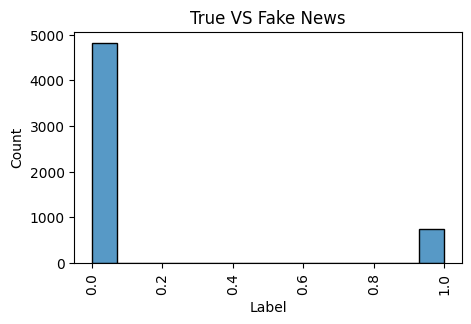

In [26]:
plt.figure(figsize=(5,3))
sns.histplot(df.Label)
plt.tick_params(axis = 'x', rotation = 90)
plt.title('True VS Fake News')
df.Label.value_counts()

In [27]:
y = df['Label']
X = df['text']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 10)

#### BERT MODEL

BERT Stands for Bi-Directional Encoder Representations from Transformers. It consists of several Transformer Encoders stacked together. It uses Transformers to understand the contextual relation between words in a sentence/text. BERT Transformer generally has two mechanisms: An encoder that reads the text input and a decoder that predicts for a given task.

In [28]:
from transformers import AutoTokenizer
def tokenize(X):
    X = tokenizer(text = list(X), add_special_tokens = True,
        max_length = 100, truncation = True,
        padding = 'max_length', return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True, verbose = True)
    return X
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [29]:
X_train_tokens = tokenize(X_train)
X_test_tokens = tokenize(X_test)

In [30]:
Length = 100
def get_model():
    dropout_rate = 0.2
    input_ids = Input(shape = (Length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (Length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    out = Dropout(0.2)(embeddings)
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True

    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [31]:
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model_1/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model_1'")


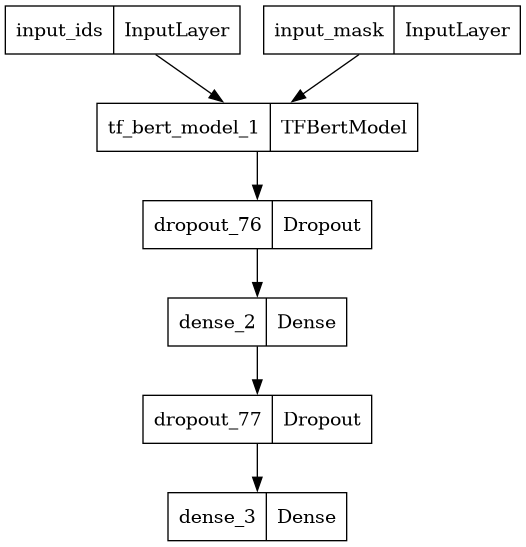

In [32]:
model = get_model()
tf.keras.utils.plot_model(model)

In [33]:
from keras.callbacks import EarlyStopping
history = model.fit(x = {'input_ids':X_train_tokens['input_ids'],
'input_mask':X_train_tokens['attention_mask']}, y = y_train, 
epochs=3, validation_split = 0.2, batch_size = 64, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max',
patience=3,verbose=False,restore_best_weights=True)])

Epoch 1/3
56/56 [==============================] - 1923s 34s/step - loss: 0.2010 - accuracy: 0.9265 - val_loss: 0.0457 - val_accuracy: 0.9877
Epoch 2/3
56/56 [==============================] - 1896s 34s/step - loss: 0.0386 - accuracy: 0.9913 - val_loss: 0.0242 - val_accuracy: 0.9955
Epoch 3/3
56/56 [==============================] - 1827s 33s/step - loss: 0.0216 - accuracy: 0.9955 - val_loss: 0.0281 - val_accuracy: 0.9933


In [37]:
yhat = np.where(model.predict({ 'input_ids' : X_test_tokens['input_ids'] , 'input_mask' : X_test_tokens['attention_mask']}) >=0.5,1,0)
print(classification_report(y_test,yhat))

35/35 [==============================] - 161s 5s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



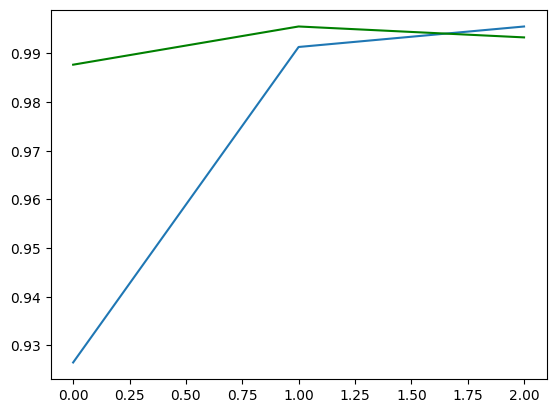

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], 'g')
plt.show()